# Car Insurance Telematics - Claim Probability Model

**Notebook 2: XGBoost Classification with Optuna Optimization**

This notebook develops a machine learning model to predict claim probability using telematics features.

## Objectives:
- Build XGBoost classification model for claim prediction
- Optimize hyperparameters using Optuna
- Evaluate model performance with cross-validation
- Analyze feature importance
- Generate business insights

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, 
                           roc_auc_score, roc_curve, precision_recall_curve,
                           f1_score, precision_score, recall_score, accuracy_score)

# Hyperparameter optimization
import optuna
# from optuna.integration import XGBoostPruningCallback

# Utilities
import joblib
from datetime import datetime
import os

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("XGBoost Claim Probability Model")
print("=" * 50)
print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

XGBoost Claim Probability Model
Timestamp: 2025-07-12 21:47:43


## 1. Data Loading and Preparation

In [2]:
# Load processed features
data_path = '../data/processed/'

# Load driver-level features (main dataset for modeling)
df = pd.read_csv(os.path.join(data_path, 'driver_level_features.csv'))

print(f"Dataset shape: {df.shape}")
print(f"\nDataset info:")
df.info()

# Display first few rows
df.head()

Dataset shape: (1200, 55)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 55 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   driver_id                       1200 non-null   object 
 1   total_trips                     1200 non-null   int64  
 2   duration_minutes_mean           1200 non-null   float64
 3   duration_minutes_std            1200 non-null   float64
 4   total_driving_time_minutes      1200 non-null   float64
 5   distance_miles_mean             1200 non-null   float64
 6   distance_miles_std              1200 non-null   float64
 7   total_distance_miles            1200 non-null   float64
 8   average_speed_mph_mean          1200 non-null   float64
 9   average_speed_mph_std           1200 non-null   float64
 10  max_speed_mph_mean              1200 non-null   float64
 11  max_speed_mph_max               1200 non-null   float6

,driver_id,total_trips,duration_minutes_mean,duration_minutes_std,total_driving_time_minutes,distance_miles_mean,distance_miles_std,total_distance_miles,average_speed_mph_mean,average_speed_mph_std,...,avg_duration_per_trip,harsh_driving_intensity,speed_risk_score,distraction_risk_score,timing_risk_score,composite_risk_score,risk_category,high_mileage_driver,frequent_driver,consistent_driver
0,0002af179ff1223f,12,32.6250,22.2946,391.5,19.2492,12.2774,230.99,39.0583,6.1187,...,32.625000,3.2500,0.03908,0.0000,9.5830,34.428324,High,0,0,1
1,003485c0a33db1b4,17,24.0529,12.4703,408.9,10.1388,6.6773,172.36,29.6059,4.7059,...,24.052941,2.5295,0.03780,4.0386,9.7065,29.266940,High,0,0,1
2,00b03adcdee26a16,9,28.9889,21.1209,260.9,24.0533,22.5892,216.48,47.6333,4.9513,...,28.988889,11.2222,0.13904,0.8990,9.4435,114.601912,Very High,0,0,1
3,00c67cb4783ab2fa,18,23.7889,9.5601,428.2,18.0206,7.8179,324.37,49.1833,4.1490,...,23.788889,9.5000,0.11128,1.0238,9.7225,97.489784,Very High,0,0,1
4,00c89280fe405154,17,23.0824,12.5857,392.4,12.4771,6.7808,212.11,30.6824,4.3216,...,23.082353,1.0000,0.01004,1.7294,7.6475,12.397212,Medium,0,0,1


In [3]:
# Create synthetic claim labels for demonstration
# In real scenario, you would have actual claim data
np.random.seed(42)

# Create claim probability based on risk factors (more realistic simulation)
claim_prob = (
    0.05 +  # Base claim rate
    0.15 * (df['composite_risk_score'] / df['composite_risk_score'].max()) +
    0.10 * df['harsh_driving_intensity'] / df['harsh_driving_intensity'].max() +
    0.08 * df['speed_risk_score'] / df['speed_risk_score'].max() +
    0.05 * df['distraction_risk_score'] / df['distraction_risk_score'].max()
)

# Cap probability at reasonable level
claim_prob = np.clip(claim_prob, 0, 0.4)

# Generate binary claims based on probability
df['has_claim'] = np.random.binomial(1, claim_prob)

print(f"Claim distribution:")
print(df['has_claim'].value_counts())
print(f"\nClaim rate: {df['has_claim'].mean():.3f}")

# Note: Replace this section with actual claim data loading in production

Claim distribution:
has_claim
0    1030
1     170
Name: count, dtype: int64

Claim rate: 0.142


## 2. Feature Selection and Preprocessing

In [4]:
# Define features for modeling
# Exclude ID columns and target variable
exclude_cols = ['driver_id', 'has_claim', 'risk_category']  # risk_category is categorical
feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"Total features available: {len(feature_cols)}")
print(f"\nSelected features:")
for i, feature in enumerate(feature_cols, 1):
    print(f"{i:2d}. {feature}")

Total features available: 53

Selected features:
 1. total_trips
 2. duration_minutes_mean
 3. duration_minutes_std
 4. total_driving_time_minutes
 5. distance_miles_mean
 6. distance_miles_std
 7. total_distance_miles
 8. average_speed_mph_mean
 9. average_speed_mph_std
10. max_speed_mph_mean
11. max_speed_mph_max
12. harsh_braking_events_mean
13. harsh_braking_events_sum
14. harsh_acceleration_events_mean
15. harsh_acceleration_events_sum
16. sharp_cornering_events_mean
17. sharp_cornering_events_sum
18. total_harsh_events_mean
19. total_harsh_events_sum
20. harsh_events_per_mile_mean
21. harsh_events_per_minute_mean
22. phone_usage_seconds_mean
23. phone_usage_seconds_sum
24. phone_usage_percent_mean
25. phone_usage_flag_mean
26. excessive_phone_use_mean
27. speeding_percent_mean
28. speed_variance_mean
29. speed_ratio_mean
30. high_speed_flag_mean
31. excessive_speed_flag_mean
32. night_driving_mean
33. rush_hour_mean
34. high_risk_time_mean
35. long_trip_flag_mean
36. short_trip_f

In [5]:
# Prepare features and target
X = df[feature_cols].copy()
y = df['has_claim'].copy()

# Handle any missing values
print(f"Missing values per feature:")
missing_counts = X.isnull().sum()
if missing_counts.sum() > 0:
    print(missing_counts[missing_counts > 0])
    # Fill missing values with median
    X = X.fillna(X.median())
else:
    print("No missing values found")

# Check for infinite values
inf_counts = np.isinf(X).sum()
if inf_counts.sum() > 0:
    print(f"\nInfinite values found:")
    print(inf_counts[inf_counts > 0])
    X = X.replace([np.inf, -np.inf], np.nan).fillna(X.median())

print(f"\nFinal feature matrix shape: {X.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")

Missing values per feature:
No missing values found

Final feature matrix shape: (1200, 53)
Target distribution: {0: 1030, 1: 170}


## 3. Train-Test Split and Cross-Validation Setup

In [6]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTrain claim rate: {y_train.mean():.3f}")
print(f"Test claim rate: {y_test.mean():.3f}")

# Setup cross-validation
cv_folds = 3  # due to run time constraints I set it to 3
cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

print(f"\nCross-validation: {cv_folds}-fold stratified")

Training set: 960 samples
Test set: 240 samples

Train claim rate: 0.142
Test claim rate: 0.142

Cross-validation: 3-fold stratified


## 4. Baseline Model Performance

In [7]:
# Train baseline XGBoost model
baseline_model = xgb.XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    verbosity=0
)

# Cross-validation scores
cv_scores = {
    'f1': cross_val_score(baseline_model, X_train, y_train, cv=cv, scoring='f1'),
    'precision': cross_val_score(baseline_model, X_train, y_train, cv=cv, scoring='precision'),
    'recall': cross_val_score(baseline_model, X_train, y_train, cv=cv, scoring='recall'),
    'roc_auc': cross_val_score(baseline_model, X_train, y_train, cv=cv, scoring='roc_auc')
}

print("Baseline Model Cross-Validation Results:")
print("=" * 45)
for metric, scores in cv_scores.items():
    print(f"{metric.upper():>10}: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

# Train on full training set for feature importance
baseline_model.fit(X_train, y_train)
baseline_pred = baseline_model.predict(X_test)
baseline_pred_proba = baseline_model.predict_proba(X_test)[:, 1]

print(f"\nBaseline Test Set Performance:")
print(f"F1 Score: {f1_score(y_test, baseline_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, baseline_pred_proba):.4f}")

Baseline Model Cross-Validation Results:
        F1: 0.0366 (+/- 0.0594)
 PRECISION: 0.1037 (+/- 0.1636)
    RECALL: 0.0222 (+/- 0.0363)
   ROC_AUC: 0.5240 (+/- 0.0394)

Baseline Test Set Performance:
F1 Score: 0.2222
ROC AUC: 0.5762


## 5. Hyperparameter Optimization with Optuna

In [8]:
def objective(trial):
    """Optuna objective function for hyperparameter optimization"""
    
    # Suggest hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'random_state': 42,
        'eval_metric': 'logloss',
        'verbosity': 0
    }
    
    # Create model
    model = xgb.XGBClassifier(**params)
    
    # Cross-validation with F1 score (primary metric for insurance claims)
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
    
    return cv_scores.mean()

# Create study
study = optuna.create_study(
    direction='maximize',
    study_name='xgboost_claim_prediction',
    sampler=optuna.samplers.TPESampler(seed=42)
)

print("Starting hyperparameter optimization...")

# Optimize
study.optimize(objective, n_trials=20, show_progress_bar=True)

print(f"\nOptimization completed!")
print(f"Best F1 score: {study.best_value:.4f}")
print(f"\nBest parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-07-12 21:49:10,608] A new study created in memory with name: xgboost_claim_prediction


Starting hyperparameter optimization...
This may take several minutes...


Best trial: 0. Best value: 0.034127:   5%|▌         | 1/20 [00:54<17:06, 54.04s/it]

[I 2025-07-12 21:50:04,647] Trial 0 finished with value: 0.034126984126984124 and parameters: {'n_estimators': 437, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'reg_alpha': 2.5348407664333426e-07, 'reg_lambda': 3.3323645788192616e-08, 'min_child_weight': 9, 'gamma': 0.0006440507553993703}. Best is trial 0 with value: 0.034126984126984124.


Best trial: 1. Best value: 0.0444444:  10%|█         | 2/20 [02:03<18:54, 63.05s/it]

[I 2025-07-12 21:51:14,005] Trial 1 finished with value: 0.044444444444444446 and parameters: {'n_estimators': 737, 'max_depth': 3, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'reg_alpha': 4.329370014459266e-07, 'reg_lambda': 4.4734294104626844e-07, 'min_child_weight': 4, 'gamma': 0.00015777981883364995}. Best is trial 1 with value: 0.044444444444444446.


Best trial: 1. Best value: 0.0444444:  15%|█▌        | 3/20 [03:06<17:50, 62.99s/it]

[I 2025-07-12 21:52:16,911] Trial 2 finished with value: 0.034920634920634915 and parameters: {'n_estimators': 489, 'max_depth': 5, 'learning_rate': 0.08012737503998542, 'subsample': 0.6557975442608167, 'colsample_bytree': 0.7168578594140873, 'reg_alpha': 1.9826980964985924e-05, 'reg_lambda': 0.00012724181576752517, 'min_child_weight': 8, 'gamma': 3.9572205641009174e-07}. Best is trial 1 with value: 0.044444444444444446.


Best trial: 1. Best value: 0.0444444:  20%|██        | 4/20 [04:31<19:07, 71.74s/it]

[I 2025-07-12 21:53:42,085] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 563, 'max_depth': 7, 'learning_rate': 0.011711509955524094, 'subsample': 0.8430179407605753, 'colsample_bytree': 0.6682096494749166, 'reg_alpha': 3.850031979199519e-08, 'reg_lambda': 3.4671276804481113, 'min_child_weight': 10, 'gamma': 0.02932100047183291}. Best is trial 1 with value: 0.044444444444444446.


Best trial: 4. Best value: 0.0472164:  25%|██▌       | 5/20 [05:12<15:07, 60.49s/it]

[I 2025-07-12 21:54:22,622] Trial 4 finished with value: 0.047216396462376686 and parameters: {'n_estimators': 374, 'max_depth': 3, 'learning_rate': 0.1024932221692416, 'subsample': 0.7760609974958406, 'colsample_bytree': 0.6488152939379115, 'reg_alpha': 0.00028614897264046574, 'reg_lambda': 2.039373116525212e-08, 'min_child_weight': 10, 'gamma': 1.1755466083160747e-06}. Best is trial 4 with value: 0.047216396462376686.


Best trial: 4. Best value: 0.0472164:  30%|███       | 6/20 [06:12<14:06, 60.48s/it]

[I 2025-07-12 21:55:23,087] Trial 5 finished with value: 0.02666666666666667 and parameters: {'n_estimators': 696, 'max_depth': 5, 'learning_rate': 0.05864129169696527, 'subsample': 0.8186841117373118, 'colsample_bytree': 0.6739417822102108, 'reg_alpha': 5.324289357128436, 'reg_lambda': 0.09466630153726856, 'min_child_weight': 10, 'gamma': 0.14408501080722544}. Best is trial 4 with value: 0.047216396462376686.


Best trial: 4. Best value: 0.0472164:  35%|███▌      | 7/20 [08:42<19:27, 89.82s/it]

[I 2025-07-12 21:57:53,304] Trial 6 finished with value: 0.026143790849673203 and parameters: {'n_estimators': 638, 'max_depth': 10, 'learning_rate': 0.01351182947645082, 'subsample': 0.6783931449676581, 'colsample_bytree': 0.6180909155642152, 'reg_alpha': 8.471746987003668e-06, 'reg_lambda': 3.148441347423712e-05, 'min_child_weight': 3, 'gamma': 0.04264813784432918}. Best is trial 4 with value: 0.047216396462376686.


Best trial: 7. Best value: 0.0505838:  40%|████      | 8/20 [09:40<15:56, 79.67s/it]

[I 2025-07-12 21:58:51,241] Trial 7 finished with value: 0.05058376627004078 and parameters: {'n_estimators': 421, 'max_depth': 5, 'learning_rate': 0.06333268775321842, 'subsample': 0.6563696899899051, 'colsample_bytree': 0.9208787923016158, 'reg_alpha': 4.6876566400928895e-08, 'reg_lambda': 7.620481786158549, 'min_child_weight': 8, 'gamma': 3.8879928024075543e-07}. Best is trial 7 with value: 0.05058376627004078.


Best trial: 7. Best value: 0.0505838:  45%|████▌     | 9/20 [10:08<11:39, 63.58s/it]

[I 2025-07-12 21:59:19,436] Trial 8 finished with value: 0.048639017524164295 and parameters: {'n_estimators': 104, 'max_depth': 9, 'learning_rate': 0.11069143219393454, 'subsample': 0.8916028672163949, 'colsample_bytree': 0.9085081386743783, 'reg_alpha': 4.638759594322625e-08, 'reg_lambda': 1.683416412018213e-05, 'min_child_weight': 2, 'gamma': 0.08032068562667222}. Best is trial 7 with value: 0.05058376627004078.


Best trial: 7. Best value: 0.0505838:  50%|█████     | 10/20 [11:50<12:34, 75.47s/it]

[I 2025-07-12 22:01:01,535] Trial 9 finished with value: 0.013888888888888888 and parameters: {'n_estimators': 661, 'max_depth': 5, 'learning_rate': 0.012413189635294229, 'subsample': 0.7243929286862649, 'colsample_bytree': 0.7300733288106989, 'reg_alpha': 0.036851536911881845, 'reg_lambda': 0.005470376807480391, 'min_child_weight': 9, 'gamma': 5.994036749692399e-05}. Best is trial 7 with value: 0.05058376627004078.


Best trial: 7. Best value: 0.0505838:  55%|█████▌    | 11/20 [14:06<14:05, 93.92s/it]

[I 2025-07-12 22:03:17,282] Trial 10 finished with value: 0.036821040594625494 and parameters: {'n_estimators': 951, 'max_depth': 7, 'learning_rate': 0.029323105618991638, 'subsample': 0.6071847502459278, 'colsample_bytree': 0.9924283304357214, 'reg_alpha': 0.016301353379407527, 'reg_lambda': 5.719260088479239, 'min_child_weight': 6, 'gamma': 2.081597936102225e-08}. Best is trial 7 with value: 0.05058376627004078.


Best trial: 7. Best value: 0.0505838:  60%|██████    | 12/20 [14:16<09:07, 68.42s/it]

[I 2025-07-12 22:03:27,393] Trial 11 finished with value: 0.0 and parameters: {'n_estimators': 104, 'max_depth': 8, 'learning_rate': 0.19265640527744946, 'subsample': 0.9732335194426311, 'colsample_bytree': 0.9148977491943684, 'reg_alpha': 1.5351121797910752e-08, 'reg_lambda': 4.806349849475463e-06, 'min_child_weight': 1, 'gamma': 0.9647633433058268}. Best is trial 7 with value: 0.05058376627004078.


Best trial: 7. Best value: 0.0505838:  65%|██████▌   | 13/20 [14:41<06:26, 55.22s/it]

[I 2025-07-12 22:03:52,240] Trial 12 finished with value: 0.0 and parameters: {'n_estimators': 110, 'max_depth': 9, 'learning_rate': 0.035631879043607706, 'subsample': 0.8959926730523962, 'colsample_bytree': 0.8624306017432581, 'reg_alpha': 2.9536889586486034e-06, 'reg_lambda': 0.00445437224264839, 'min_child_weight': 6, 'gamma': 5.462542782320958e-06}. Best is trial 7 with value: 0.05058376627004078.


Best trial: 7. Best value: 0.0505838:  70%|███████   | 14/20 [15:35<05:29, 54.84s/it]

[I 2025-07-12 22:04:46,196] Trial 13 finished with value: 0.03751187084520418 and parameters: {'n_estimators': 257, 'max_depth': 6, 'learning_rate': 0.03891469423179501, 'subsample': 0.7631435327819819, 'colsample_bytree': 0.8461973930102327, 'reg_alpha': 1.698030369119436e-08, 'reg_lambda': 0.008179330845999084, 'min_child_weight': 2, 'gamma': 0.0030481537207848425}. Best is trial 7 with value: 0.05058376627004078.


Best trial: 14. Best value: 0.0561787:  75%|███████▌  | 15/20 [16:20<04:18, 51.76s/it]

[I 2025-07-12 22:05:30,815] Trial 14 finished with value: 0.056178698111398716 and parameters: {'n_estimators': 292, 'max_depth': 4, 'learning_rate': 0.15060012076725598, 'subsample': 0.8952393368504931, 'colsample_bytree': 0.9570122700768573, 'reg_alpha': 0.00016118649078143831, 'reg_lambda': 1.310872921506698e-06, 'min_child_weight': 7, 'gamma': 2.626329270646006e-08}. Best is trial 14 with value: 0.056178698111398716.


Best trial: 14. Best value: 0.0561787:  80%|████████  | 16/20 [17:01<03:14, 48.61s/it]

[I 2025-07-12 22:06:12,128] Trial 15 finished with value: 0.04371584699453552 and parameters: {'n_estimators': 324, 'max_depth': 4, 'learning_rate': 0.14920643617808255, 'subsample': 0.6043956756975085, 'colsample_bytree': 0.9851583965712964, 'reg_alpha': 0.0005224845319424447, 'reg_lambda': 1.320654555073657e-06, 'min_child_weight': 7, 'gamma': 2.302959673608843e-08}. Best is trial 14 with value: 0.056178698111398716.


Best trial: 14. Best value: 0.0561787:  85%|████████▌ | 17/20 [17:36<02:13, 44.64s/it]

[I 2025-07-12 22:06:47,527] Trial 16 finished with value: 0.03726997437689261 and parameters: {'n_estimators': 243, 'max_depth': 4, 'learning_rate': 0.058734268666402314, 'subsample': 0.9918585998724917, 'colsample_bytree': 0.9362148766913249, 'reg_alpha': 0.00044081640472577743, 'reg_lambda': 0.26849726389645745, 'min_child_weight': 7, 'gamma': 1.603443873037273e-07}. Best is trial 14 with value: 0.056178698111398716.


Best trial: 14. Best value: 0.0561787:  90%|█████████ | 18/20 [17:59<01:15, 37.98s/it]

[I 2025-07-12 22:07:09,987] Trial 17 finished with value: 0.027494331065759634 and parameters: {'n_estimators': 240, 'max_depth': 6, 'learning_rate': 0.25578634207532824, 'subsample': 0.720796288944333, 'colsample_bytree': 0.7852715380551614, 'reg_alpha': 8.927038528319232, 'reg_lambda': 0.0003639035663823041, 'min_child_weight': 5, 'gamma': 2.101508604735529e-06}. Best is trial 14 with value: 0.056178698111398716.


Best trial: 14. Best value: 0.0561787:  95%|█████████▌| 19/20 [20:08<01:05, 65.45s/it]

[I 2025-07-12 22:09:19,443] Trial 18 finished with value: 0.03636363636363636 and parameters: {'n_estimators': 887, 'max_depth': 4, 'learning_rate': 0.022444362409947183, 'subsample': 0.8970303337810757, 'colsample_bytree': 0.9527222822682909, 'reg_alpha': 0.05190925408128149, 'reg_lambda': 1.8664318314213132e-07, 'min_child_weight': 8, 'gamma': 1.4464162581716166e-05}. Best is trial 14 with value: 0.056178698111398716.


Best trial: 14. Best value: 0.0561787: 100%|██████████| 20/20 [21:16<00:00, 63.80s/it]

[I 2025-07-12 22:10:26,610] Trial 19 finished with value: 0.047474747474747475 and parameters: {'n_estimators': 528, 'max_depth': 3, 'learning_rate': 0.07570442988170792, 'subsample': 0.9433652849644489, 'colsample_bytree': 0.8388049554799257, 'reg_alpha': 0.00418029541435174, 'reg_lambda': 0.0005428366042137893, 'min_child_weight': 5, 'gamma': 7.796924348879079e-08}. Best is trial 14 with value: 0.056178698111398716.

Optimization completed!
Best F1 score: 0.0562

Best parameters:
  n_estimators: 292
  max_depth: 4
  learning_rate: 0.15060012076725598
  subsample: 0.8952393368504931
  colsample_bytree: 0.9570122700768573
  reg_alpha: 0.00016118649078143831
  reg_lambda: 1.310872921506698e-06
  min_child_weight: 7
  gamma: 2.626329270646006e-08


## 6. Final Model Training and Evaluation

In [9]:
# Train final model with best parameters
best_params = study.best_params.copy()
best_params.update({
    'random_state': 42,
    'eval_metric': 'logloss',
    'verbosity': 0
})

final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X_train, y_train)

# Predictions
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# Comprehensive evaluation
print("FINAL MODEL PERFORMANCE")
print("=" * 50)

# Classification metrics
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_pred_proba):.4f}")

# Detailed classification report
print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['No Claim', 'Claim']))

# Cross-validation with final model
final_cv_scores = {
    'f1': cross_val_score(final_model, X_train, y_train, cv=cv, scoring='f1'),
    'precision': cross_val_score(final_model, X_train, y_train, cv=cv, scoring='precision'),
    'recall': cross_val_score(final_model, X_train, y_train, cv=cv, scoring='recall'),
    'roc_auc': cross_val_score(final_model, X_train, y_train, cv=cv, scoring='roc_auc')
}

print(f"\nCross-Validation Results (Final Model):")
print("=" * 45)
for metric, scores in final_cv_scores.items():
    print(f"{metric.upper():>10}: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

FINAL MODEL PERFORMANCE
Accuracy:  0.8208
Precision: 0.1538
Recall:    0.0588
F1 Score:  0.0851
ROC AUC:   0.5850

Detailed Classification Report:
              precision    recall  f1-score   support

    No Claim       0.86      0.95      0.90       206
       Claim       0.15      0.06      0.09        34

    accuracy                           0.82       240
   macro avg       0.51      0.50      0.49       240
weighted avg       0.76      0.82      0.79       240


Cross-Validation Results (Final Model):
        F1: 0.0562 (+/- 0.0333)
 PRECISION: 0.1194 (+/- 0.0820)
    RECALL: 0.0369 (+/- 0.0214)
   ROC_AUC: 0.5204 (+/- 0.0626)


## 7. Model Visualization and Analysis

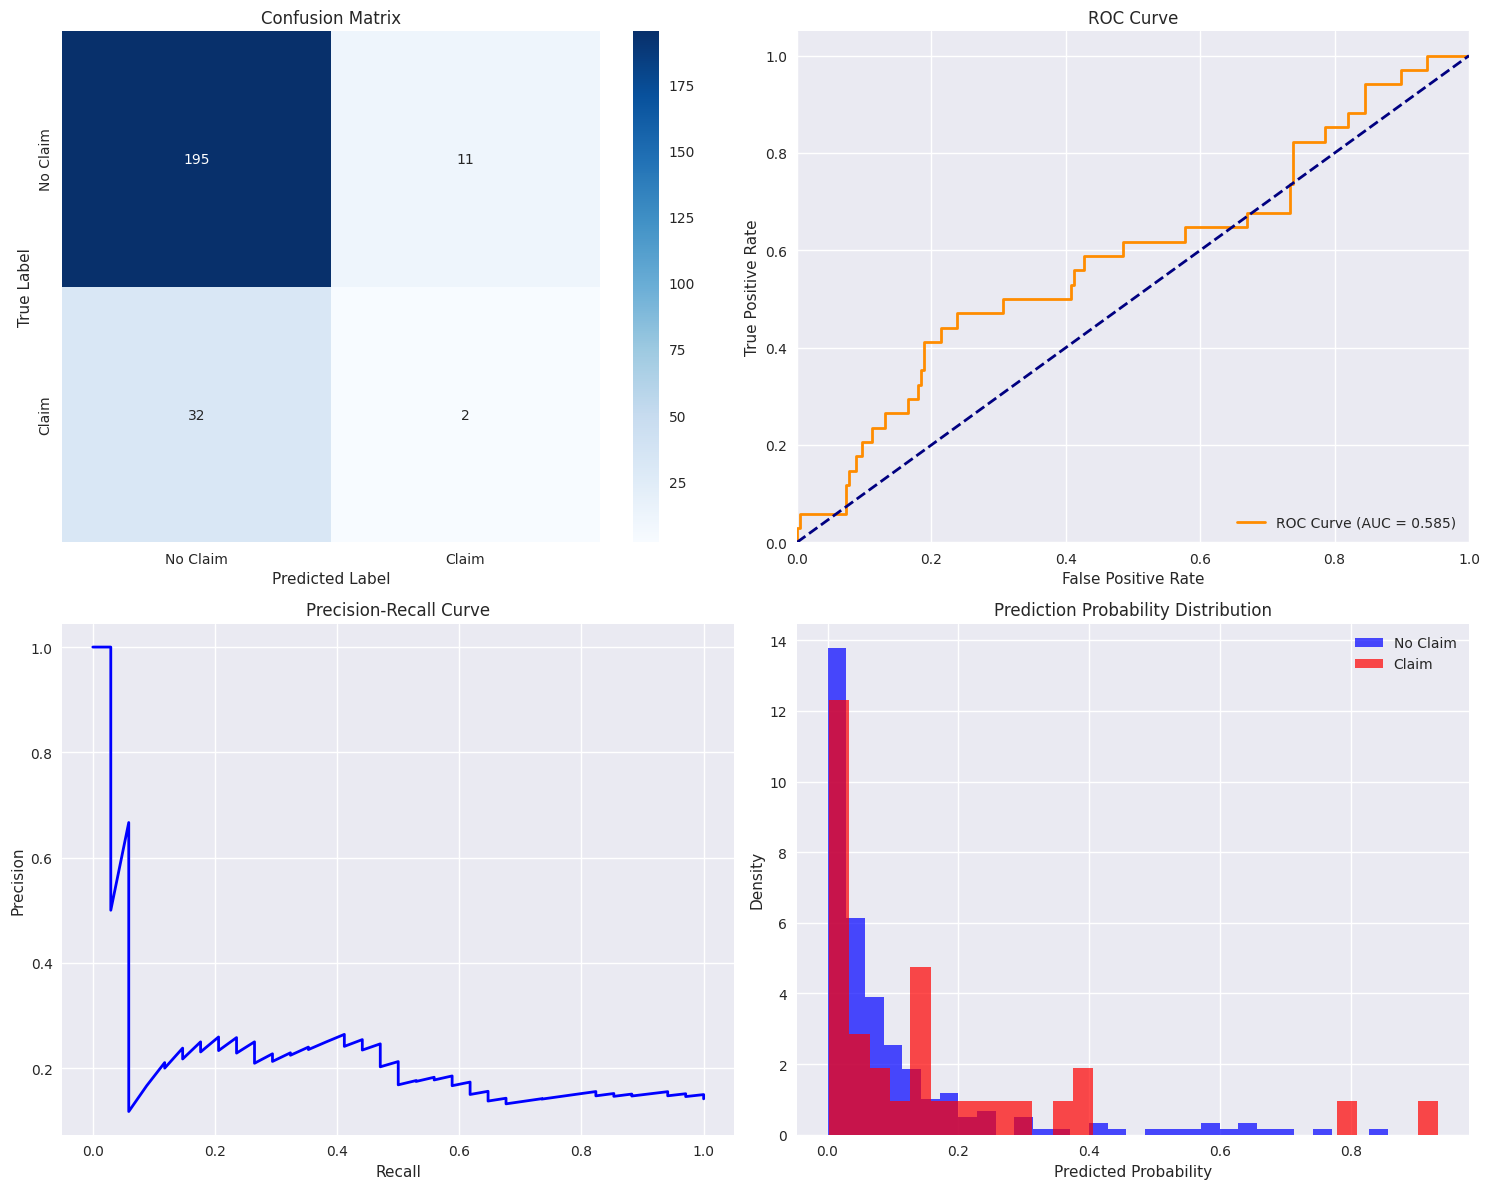

In [10]:
# Create visualization plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Claim', 'Claim'],
            yticklabels=['No Claim', 'Claim'],
            ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix')
axes[0,0].set_ylabel('True Label')
axes[0,0].set_xlabel('Predicted Label')

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
axes[0,1].plot(fpr, tpr, color='darkorange', lw=2, 
               label=f'ROC Curve (AUC = {roc_auc:.3f})')
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,1].set_xlim([0.0, 1.0])
axes[0,1].set_ylim([0.0, 1.05])
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve')
axes[0,1].legend(loc="lower right")
axes[0,1].grid(True)

# 3. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
axes[1,0].plot(recall, precision, color='blue', lw=2)
axes[1,0].set_xlabel('Recall')
axes[1,0].set_ylabel('Precision')
axes[1,0].set_title('Precision-Recall Curve')
axes[1,0].grid(True)

# 4. Prediction Probability Distribution
axes[1,1].hist(y_pred_proba[y_test == 0], bins=30, alpha=0.7, 
               label='No Claim', color='blue', density=True)
axes[1,1].hist(y_pred_proba[y_test == 1], bins=30, alpha=0.7, 
               label='Claim', color='red', density=True)
axes[1,1].set_xlabel('Predicted Probability')
axes[1,1].set_ylabel('Density')
axes[1,1].set_title('Prediction Probability Distribution')
axes[1,1].legend()
axes[1,1].grid(True)

plt.tight_layout()
plt.savefig('model_evaluation_plots.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Feature Importance Analysis

TOP 15 MOST IMPORTANT FEATURES
 1. total_harsh_events_mean             0.0440
 2. harsh_acceleration_events_sum       0.0372
 3. harsh_events_per_mile_mean          0.0356
 4. max_speed_mph_mean                  0.0337
 5. rush_hour_mean                      0.0315
 6. phone_usage_seconds_mean            0.0301
 7. harsh_braking_events_mean           0.0301
 8. sharp_cornering_events_sum          0.0293
 9. distraction_risk_score              0.0284
10. duration_minutes_std                0.0283
11. high_risk_time_mean                 0.0249
12. harsh_events_per_minute_mean        0.0242
13. data_quality_score_mean             0.0240
14. short_trip_flag_mean                0.0235
15. phone_usage_seconds_sum             0.0234


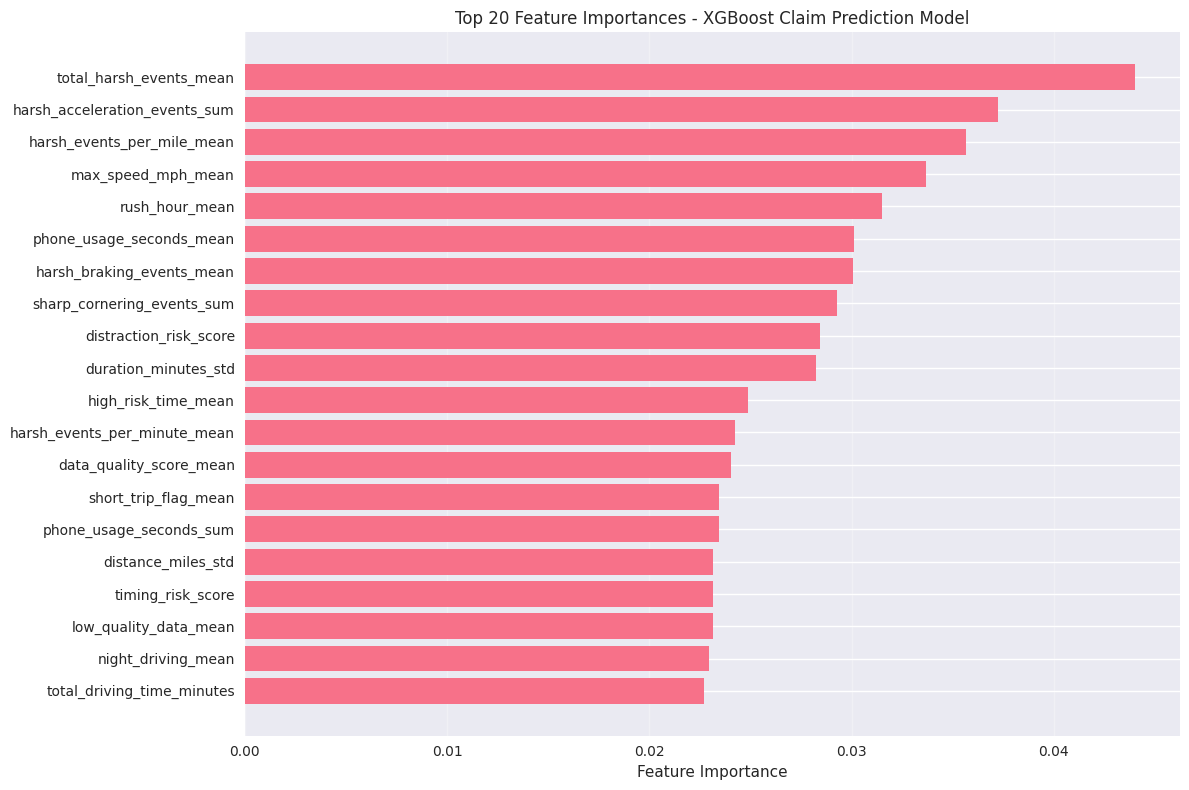


✓ Feature importance saved to: feature_importance.csv


In [11]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

# Display top features
print("TOP 15 MOST IMPORTANT FEATURES")
print("=" * 50)
for i, (_, row) in enumerate(feature_importance.head(15).iterrows(), 1):
    print(f"{i:2d}. {row['feature']:<35} {row['importance']:.4f}")

# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances - XGBoost Claim Prediction Model')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Save feature importance
feature_importance.to_csv('feature_importance.csv', index=False)
print(f"\n✓ Feature importance saved to: feature_importance.csv")

## 9. Business Insights and Risk Segmentation

In [12]:
# Create risk segments based on predicted probabilities
test_results = pd.DataFrame({
    'driver_id': df.loc[X_test.index, 'driver_id'],
    'actual_claim': y_test,
    'predicted_claim': y_pred,
    'claim_probability': y_pred_proba
})

# Define risk segments
test_results['risk_segment'] = pd.cut(
    test_results['claim_probability'],
    bins=[0, 0.1, 0.2, 0.3, 1.0],
    labels=['Low Risk', 'Medium Risk', 'High Risk', 'Very High Risk']
)

# Analyze segments
segment_analysis = test_results.groupby('risk_segment').agg({
    'driver_id': 'count',
    'actual_claim': ['sum', 'mean'],
    'claim_probability': ['mean', 'std']
}).round(4)

segment_analysis.columns = ['Driver_Count', 'Actual_Claims', 'Claim_Rate', 
                          'Avg_Predicted_Prob', 'Std_Predicted_Prob']

print("RISK SEGMENTATION ANALYSIS")
print("=" * 50)
print(segment_analysis)

# Calculate lift
overall_claim_rate = test_results['actual_claim'].mean()
segment_analysis['Lift'] = segment_analysis['Claim_Rate'] / overall_claim_rate

print(f"\nOverall claim rate: {overall_claim_rate:.4f}")
print(f"\nLift by segment:")
for segment, lift in segment_analysis['Lift'].items():
    print(f"  {segment}: {lift:.2f}x")

RISK SEGMENTATION ANALYSIS
                Driver_Count  Actual_Claims  Claim_Rate  Avg_Predicted_Prob  \
risk_segment                                                                  
Low Risk                 166             18      0.1084              0.0318   
Medium Risk               38              7      0.1842              0.1440   
High Risk                 11              3      0.2727              0.2383   
Very High Risk            25              6      0.2400              0.5359   

                Std_Predicted_Prob  
risk_segment                        
Low Risk                    0.0275  
Medium Risk                 0.0305  
High Risk                   0.0269  
Very High Risk              0.1847  

Overall claim rate: 0.1417

Lift by segment:
  Low Risk: 0.77x
  Medium Risk: 1.30x
  High Risk: 1.92x
  Very High Risk: 1.69x


## 10. Model Persistence and Summary

In [13]:
# Save the trained model
model_filename = 'xgboost_claim_model.pkl'
joblib.dump(final_model, model_filename)

# Save model metadata
model_metadata = {
    'model_type': 'XGBoost Classifier',
    'target': 'has_claim',
    'features': list(X_train.columns),
    'n_features': len(X_train.columns),
    'training_samples': len(X_train),
    'test_samples': len(X_test),
    'cv_folds': cv_folds,
    'best_params': study.best_params,
    'performance': {
        'test_f1': f1_score(y_test, y_pred),
        'test_precision': precision_score(y_test, y_pred),
        'test_recall': recall_score(y_test, y_pred),
        'test_roc_auc': roc_auc_score(y_test, y_pred_proba),
        'cv_f1_mean': final_cv_scores['f1'].mean(),
        'cv_f1_std': final_cv_scores['f1'].std()
    },
    'timestamp': datetime.now().isoformat()
}

# Save metadata
import json
with open('model_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=2)

# Save test results
test_results.to_csv('test_predictions.csv', index=False)
segment_analysis.to_csv('risk_segment_analysis.csv')

print("MODEL TRAINING COMPLETED SUCCESSFULLY")
print("=" * 50)
print(f"Files created:")
print(f"  1. {model_filename} - Trained XGBoost model")
print(f"  2. model_metadata.json - Model configuration and performance")
print(f"  3. feature_importance.csv - Feature importance rankings")
print(f"  4. test_predictions.csv - Test set predictions")
print(f"  5. risk_segment_analysis.csv - Risk segmentation analysis")
print(f"  6. model_evaluation_plots.png - Performance visualizations")
print(f"  7. feature_importance.png - Feature importance plot")

print(f"\nModel Performance Summary:")
print(f"  • F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"  • ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"  • Precision: {precision_score(y_test, y_pred):.4f}")
print(f"  • Recall: {recall_score(y_test, y_pred):.4f}")

print(f"\nReady for next notebook: Premium Calculation and Risk Pricing")

MODEL TRAINING COMPLETED SUCCESSFULLY
Files created:
  1. xgboost_claim_model.pkl - Trained XGBoost model
  2. model_metadata.json - Model configuration and performance
  3. feature_importance.csv - Feature importance rankings
  4. test_predictions.csv - Test set predictions
  5. risk_segment_analysis.csv - Risk segmentation analysis
  6. model_evaluation_plots.png - Performance visualizations
  7. feature_importance.png - Feature importance plot

Model Performance Summary:
  • F1 Score: 0.0851
  • ROC AUC: 0.5850
  • Precision: 0.1538
  • Recall: 0.0588

Ready for next notebook: Premium Calculation and Risk Pricing
